In [1]:
!pip install git+https://www.github.com/mouseland/cellpose.git

  Cloning https://www.github.com/mouseland/cellpose.git to /var/tmp/pbs.35513.e5-cse-cbgpu01/pip-req-build-u755k0xq
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /var/tmp/pbs.35513.e5-cse-cbgpu01/pip-req-build-u755k0xq
  Resolved https://www.github.com/mouseland/cellpose.git to commit 9d59b2eec1d644fb3d4ba0f77ff19ae2900ab706
  Preparing metadata (setup.py) ... done


Check GPU and instantiate model - will download weights.

In [2]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4.dev7+gfb5a6c0 
platform:       	linux 
python version: 	3.10.16 
torch version:  	2.7.0+cu126! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


2025-05-22 10:23:15,763 [INFO] WRITING LOG OUTPUT TO /home/grads/msa6093/.cellpose/run.log
2025-05-22 10:23:15,765 [INFO] 
cellpose version: 	4.0.4.dev7+gfb5a6c0 
platform:       	linux 
python version: 	3.10.16 
torch version:  	2.7.0+cu126
2025-05-22 10:23:16,128 [INFO] ** TORCH CUDA version installed and working. **
2025-05-22 10:23:16,129 [INFO] ** TORCH CUDA version installed and working. **
2025-05-22 10:23:16,131 [INFO] >>>> using GPU (CUDA)
2025-05-22 10:23:17,829 [INFO] >>>> loading model /home/grads/msa6093/.cellpose/models/cpsam


Input directory with your images:

In [3]:
# *** change to your google drive folder path ***
dir = "/scratch/msa6093/cellpose/Images/Layer200"
dir = Path(dir)
if not dir.exists():
  raise FileNotFoundError("directory does not exist")

# *** change to your image extension ***
image_ext = ".tif"

# Image vs mask files by filename pattern
files  = sorted([f for f in dir.glob("*.tif")
                     if "Gutcellmask" not in f.name])

# list all files
## files = natsorted([f for f in dir.glob("*"+image_ext) if "_masks" not in f.name and "_flows" not in f.name])
## 
if(len(files)==0):
  raise FileNotFoundError("no image files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} images in folder:")

for f in files:
  print(f.name)

208 images in folder:
AAA392_image_0200_y000_x000.tif
AAA392_image_0200_y000_x001.tif
AAA392_image_0200_y000_x002.tif
AAA392_image_0200_y000_x003.tif
AAA392_image_0200_y000_x004.tif
AAA392_image_0200_y000_x005.tif
AAA392_image_0200_y000_x006.tif
AAA392_image_0200_y000_x007.tif
AAA392_image_0200_y000_x008.tif
AAA392_image_0200_y000_x009.tif
AAA392_image_0200_y000_x010.tif
AAA392_image_0200_y000_x011.tif
AAA392_image_0200_y000_x012.tif
AAA392_image_0200_y000_x013.tif
AAA392_image_0200_y000_x014.tif
AAA392_image_0200_y000_x015.tif
AAA392_image_0200_y001_x000.tif
AAA392_image_0200_y001_x001.tif
AAA392_image_0200_y001_x002.tif
AAA392_image_0200_y001_x003.tif
AAA392_image_0200_y001_x004.tif
AAA392_image_0200_y001_x005.tif
AAA392_image_0200_y001_x006.tif
AAA392_image_0200_y001_x007.tif
AAA392_image_0200_y001_x008.tif
AAA392_image_0200_y001_x009.tif
AAA392_image_0200_y001_x010.tif
AAA392_image_0200_y001_x011.tif
AAA392_image_0200_y001_x012.tif
AAA392_image_0200_y001_x013.tif
AAA392_image_0200_

## Run Cellpose-SAM on one image in folder

Here are some of the parameters you can change:

* ***flow_threshold*** is  the  maximum  allowed  error  of  the  flows  for  each  mask.   The  default  is 0.4.
    *  **Increase** this threshold if cellpose is not returning as many masks as you’d expect (or turn off completely with 0.0)
    *   **Decrease** this threshold if cellpose is returning too many ill-shaped masks.

* ***cellprob_threshold*** determines proability that a detected object is a cell.   The  default  is 0.0.
    *   **Decrease** this threshold if cellpose is not returning as many masks as you’d expect or if masks are too small
    *   **Increase** this threshold if cellpose is returning too many masks esp from dull/dim areas.

* ***tile_norm_blocksize*** determines the size of blocks used for normalizing the image. The default is 0, which means the entire image is normalized together.
  You may want to change this to 100-200 pixels if you have very inhomogeneous brightness across your image.



In [409]:
##
## Tif files
##

## look at those again: 51, 52, 69

image_number = 69


img = io.imread(files[image_number])

print(f'your image has shape: {img.shape}. Assuming channel dimension is last with {img.shape[-1]} channels')
image_coords = files[image_number].name[:-4]



first_channel = '0' # @param ['None', 0, 1, 2, 3, 4, 5]
second_channel = '1' # @param ['None', 0, 1, 2, 3, 4, 5]
third_channel = 'None' # @param ['None', 0, 1, 2, 3, 4, 5]


'''
##
##  Nii files
##

import nibabel as nib

# load the NIfTI file
nii = nib.load(files[0])

# get the image data as a NumPy array
img = nii.get_fdata()

print(f'your image has shape: {img.shape}')
'''

your image has shape: (256, 256). Assuming channel dimension is last with 256 channels


"\n##\n##  Nii files\n##\n\nimport nibabel as nib\n\n# load the NIfTI file\nnii = nib.load(files[0])\n\n# get the image data as a NumPy array\nimg = nii.get_fdata()\n\nprint(f'your image has shape: {img.shape}')\n"

### Channel Selection: 

- Use the dropdowns below to select the _zero-indexed_ channels of your image to segment. The order does not matter. Remember to rerun the cell after you edit the dropdowns.

- If you have a histological image taken in brightfield, you don't need to adjust the channels.

- If you have a fluroescent image with multiple stains, you should choose one channel with a cytoplasm/membrane stain, one channel with a nuclear stain, and set the third channel to `None`. Choosing multiple channels may produce segmentaiton of all the structures in the image. If you have retrained the model on your data with a thrid stain (described below), you can run segmentation with all channels. 

In [ ]:
## first_channel = '0' # @param ['None', 0, 1, 2, 3, 4, 5]
## second_channel = '1' # @param ['None', 0, 1, 2, 3, 4, 5]
## third_channel = 'None' # @param ['None', 0, 1, 2, 3, 4, 5]

2025-05-22 11:44:58,547 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


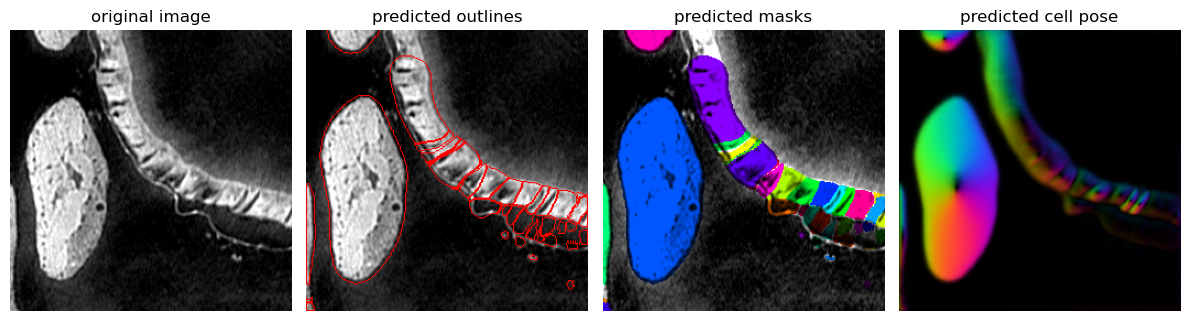

In [412]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import plot
import tifffile
import nibabel as nib
from pathlib import Path
from PIL import Image

'''
selected_channels = []
for i, c in enumerate([first_channel, second_channel, third_channel]):
  if c == 'None':
    continue
  if int(c) > img.shape[-1]:
    assert False, 'invalid channel index, must have index greater or equal to the number of channels'
  if c != 'None':
    selected_channels.append(int(c))



img_selected_channels = np.zeros_like(img)
img_selected_channels[:, :, :len(selected_channels)] = img[:, :, selected_channels]


flow_threshold = 0.4
cellprob_threshold = 0.0
tile_norm_blocksize = 0

masks, flows, styles = model.eval(img_selected_channels, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img_selected_channels, masks, flows[0])
plt.tight_layout()
plt.show()
'''


### 2d
# assume `img` is your NumPy array, shape = (Y, X)

masks, flows, styles = model.eval(
    img,               # ← 2-D in, Cellpose will see it as (1,1,Y,X)
    batch_size=32,
    diameter=20,
    channels=[0, 0],   # one channel only: use channel “0” for both cyto & nuclei
    flow_threshold=20.0,
    cellprob_threshold=-2.0,
    normalize={"tile_norm_blocksize": 0}
)


out_dir = Path("/scratch/msa6093/cellpose/Images/CuratedTrainingData")

# extract the mask for this one image
mask = masks[0] if isinstance(masks, (list, tuple)) else masks

# save masks ---
# 1) as a .npy
np.save(f"/scratch/msa6093/cellpose/Images/CuratedTrainingData/{image_coords}_mask.npy", mask)

# 2) as a 16-bit TIFF
tifffile.imwrite(f"/scratch/msa6093/cellpose/Images/CuratedTrainingData/{image_coords}_mask.tif", mask.astype(np.uint16))

tifffile.imwrite(f"/scratch/msa6093/cellpose/Images/CuratedTrainingData/{image_coords}.tif", img)

# 3) as a NIfTI
nii_mask = nib.Nifti1Image(mask.astype(np.int16), affine=np.eye(4))
nib.save(nii_mask, out_dir / f"{image_coords}_mask.nii.gz")

nii_img = nib.Nifti1Image(img.astype(np.float32), affine=np.eye(4))
nib.save(nii_img, out_dir / f"{image_coords}.nii.gz")


# for plotting, Cellpose wants HxWxC, so add your singleton channel now
img_hwc = img[..., np.newaxis]   # (Y, X, 1)

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img_hwc, masks, flows[0])
plt.tight_layout()
plt.show()



## Run Cellpose-SAM on folder of images

if you have many large images, you may want to run them as a loop over images



In [ ]:
'''
flow_threshold = 0.4
cellprob_threshold = 0.0
tile_norm_blocksize = 0

masks_ext = ".png" if image_ext == ".png" else ".tif"
for i in trange(len(files)):
    f = files[i]
    img = io.imread(f)
    masks, flows, styles = model.eval(img, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks)
'''

'''
import nibabel as nib
import numpy as np
from pathlib import Path
from tqdm import trange

# your Cellpose parameters
flow_threshold     = 0.4
cellprob_threshold = 0.0
tile_norm_blocksize = 0

# wherever your .nii.gz lives
files = list(Path("path/to/your/niis").glob("*.nii.gz"))
out_dir = Path("path/to/output/masks")
out_dir.mkdir(parents=True, exist_ok=True)

for f in files:
    # 1) load the volume
    nii    = nib.load(str(f))
    affine = nii.affine
    vol    = nii.get_fdata()             # shape (Y, X, Z) or (X, Y, Z)

    # make sure the slice‐axis is the last one:
    # if vol.shape is (Z,Y,X), transpose to (Y,X,Z)
    if vol.shape[0] == vol.shape[-1]:
        vol = np.transpose(vol, (1,2,0))

    Y, X, Z = vol.shape
    mask_vol = np.zeros((Y, X, Z), dtype=np.uint16)

    # 2) process slice by slice
    for z in trange(Z, desc=f"segmenting {f.name}"):
        slice2d = vol[:, :, z]            # (Y, X)

        # run Cellpose on this single 2D slice
        masks, flows, styles = model.eval(
            slice2d,
            batch_size=32,
            channels=[0, 0],               # single‐channel input
            flow_threshold=flow_threshold,
            cellprob_threshold=cellprob_threshold,
            normalize={"tile_norm_blocksize": tile_norm_blocksize}
        )

        # masks is a list of length 1, each an H×W array
        mask_vol[:, :, z] = masks[0].astype(np.uint16)

    # 3) save 3D mask as NIfTI
    mask_nii = nib.Nifti1Image(mask_vol, affine)
    out_path = out_dir / f"{f.stem}_masks.nii.gz"
    nib.save(mask_nii, str(out_path))
    print(f"→ saved {out_path}")
'''

  0%|          | 0/208 [00:00<?, ?it/s]

2025-05-22 10:55:00,800 [INFO] No cell pixels found.


  0%|          | 1/208 [00:00<00:20,  9.99it/s]

2025-05-22 10:55:00,897 [INFO] No cell pixels found.
2025-05-22 10:55:00,989 [INFO] No cell pixels found.


  1%|▏         | 3/208 [00:00<00:19, 10.68it/s]

2025-05-22 10:55:01,201 [INFO] No cell pixels found.


  2%|▏         | 5/208 [00:00<00:20,  9.98it/s]

2025-05-22 10:55:01,294 [INFO] No cell pixels found.
2025-05-22 10:55:01,386 [INFO] No cell pixels found.


  3%|▎         | 7/208 [00:00<00:19, 10.32it/s]

2025-05-22 10:55:01,478 [INFO] No cell pixels found.
2025-05-22 10:55:01,571 [INFO] No cell pixels found.


  4%|▍         | 9/208 [00:00<00:18, 10.49it/s]

2025-05-22 10:55:01,664 [INFO] No cell pixels found.
2025-05-22 10:55:01,756 [INFO] No cell pixels found.


  5%|▌         | 11/208 [00:01<00:18, 10.61it/s]

2025-05-22 10:55:01,971 [INFO] No cell pixels found.


  6%|▋         | 13/208 [00:01<00:19, 10.14it/s]

2025-05-22 10:55:02,063 [INFO] No cell pixels found.
2025-05-22 10:55:02,155 [INFO] No cell pixels found.


  7%|▋         | 15/208 [00:01<00:18, 10.35it/s]

2025-05-22 10:55:02,383 [INFO] No cell pixels found.


  8%|▊         | 17/208 [00:01<00:19,  9.75it/s]

2025-05-22 10:55:02,497 [WARNING] no seeds found in get_masks_torch - no masks found.


 11%|█         | 22/208 [00:02<00:22,  8.20it/s]

2025-05-22 10:55:03,125 [INFO] No cell pixels found.


 12%|█▏        | 24/208 [00:02<00:21,  8.37it/s]

2025-05-22 10:55:03,358 [INFO] No cell pixels found.
2025-05-22 10:55:03,450 [INFO] No cell pixels found.


 12%|█▎        | 26/208 [00:02<00:19,  9.13it/s]

2025-05-22 10:55:03,544 [INFO] No cell pixels found.
2025-05-22 10:55:03,636 [INFO] No cell pixels found.


 13%|█▎        | 28/208 [00:02<00:18,  9.66it/s]

2025-05-22 10:55:03,729 [INFO] No cell pixels found.
2025-05-22 10:55:03,822 [INFO] No cell pixels found.


 14%|█▍        | 30/208 [00:03<00:17, 10.00it/s]

2025-05-22 10:55:03,915 [INFO] No cell pixels found.
2025-05-22 10:55:04,007 [INFO] No cell pixels found.


 15%|█▌        | 32/208 [00:03<00:17, 10.24it/s]

2025-05-22 10:55:04,100 [INFO] No cell pixels found.


 17%|█▋        | 35/208 [00:03<00:18,  9.27it/s]

2025-05-22 10:55:04,455 [INFO] No cell pixels found.


 18%|█▊        | 37/208 [00:03<00:18,  9.35it/s]

2025-05-22 10:55:04,667 [INFO] No cell pixels found.


 19%|█▉        | 40/208 [00:04<00:19,  8.64it/s]

2025-05-22 10:55:05,038 [INFO] No cell pixels found.
2025-05-22 10:55:05,130 [INFO] No cell pixels found.


 20%|██        | 42/208 [00:04<00:17,  9.30it/s]

2025-05-22 10:55:05,223 [INFO] No cell pixels found.
2025-05-22 10:55:05,316 [INFO] No cell pixels found.


 21%|██        | 44/208 [00:04<00:16,  9.74it/s]

2025-05-22 10:55:05,410 [INFO] No cell pixels found.
2025-05-22 10:55:05,502 [INFO] No cell pixels found.


 22%|██▏       | 46/208 [00:04<00:16, 10.04it/s]

2025-05-22 10:55:05,595 [INFO] No cell pixels found.
2025-05-22 10:55:05,688 [INFO] No cell pixels found.


 23%|██▎       | 48/208 [00:04<00:15, 10.26it/s]

2025-05-22 10:55:05,781 [INFO] No cell pixels found.


 24%|██▍       | 50/208 [00:05<00:16,  9.80it/s]

2025-05-22 10:55:06,004 [INFO] No cell pixels found.


 26%|██▌       | 54/208 [00:05<00:19,  7.89it/s]

2025-05-22 10:55:06,568 [INFO] No cell pixels found.


 27%|██▋       | 56/208 [00:05<00:18,  8.18it/s]

2025-05-22 10:55:06,797 [INFO] No cell pixels found.
2025-05-22 10:55:06,890 [INFO] No cell pixels found.


 28%|██▊       | 58/208 [00:06<00:16,  8.91it/s]

2025-05-22 10:55:06,983 [INFO] No cell pixels found.
2025-05-22 10:55:07,075 [INFO] No cell pixels found.


 29%|██▉       | 60/208 [00:06<00:15,  9.45it/s]

2025-05-22 10:55:07,168 [INFO] No cell pixels found.
2025-05-22 10:55:07,261 [INFO] No cell pixels found.


 30%|██▉       | 62/208 [00:06<00:14,  9.84it/s]

2025-05-22 10:55:07,355 [INFO] No cell pixels found.
2025-05-22 10:55:07,447 [INFO] No cell pixels found.


 31%|███       | 64/208 [00:06<00:14, 10.11it/s]

2025-05-22 10:55:07,540 [INFO] No cell pixels found.


 32%|███▏      | 67/208 [00:07<00:15,  9.17it/s]

2025-05-22 10:55:07,903 [INFO] No cell pixels found.


 36%|███▌      | 74/208 [00:08<00:17,  7.58it/s]

2025-05-22 10:55:08,882 [INFO] No cell pixels found.
2025-05-22 10:55:08,974 [INFO] No cell pixels found.


 37%|███▋      | 76/208 [00:08<00:15,  8.69it/s]

2025-05-22 10:55:09,068 [INFO] No cell pixels found.
2025-05-22 10:55:09,161 [INFO] No cell pixels found.


 38%|███▊      | 78/208 [00:08<00:13,  9.36it/s]

2025-05-22 10:55:09,255 [INFO] No cell pixels found.
2025-05-22 10:55:09,348 [INFO] No cell pixels found.


 38%|███▊      | 80/208 [00:08<00:13,  9.81it/s]

2025-05-22 10:55:09,440 [INFO] No cell pixels found.


 40%|███▉      | 83/208 [00:09<00:14,  8.81it/s]

2025-05-22 10:55:09,839 [WARNING] no seeds found in get_masks_torch - no masks found.


 40%|████      | 84/208 [00:09<00:13,  9.08it/s]


KeyboardInterrupt: 

if you have small images, you may want to load all of them first and then run, so that they can be batched together on the GPU

In [25]:
print("loading images")
imgs = [io.imread(files[i]) for i in trange(len(files))]

print("running cellpose-SAM")
masks, flows, styles = model.eval(imgs, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

print("saving masks")
for i in trange(len(files)):
    f = files[i]
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks[i])

to save your masks for ImageJ, run the following code:

In [26]:
for i in trange(len(files)):
    f = files[i]
    masks0 = io.imsave(dir / (f.name + "_masks" + masks_ext))
    io.save_rois(masks0, f)